# Forbes list of largest US Charities Data scraping

In 2016, Forbes published an article of the top 100 largest charities in the USA, complete with links to a short, structured summary describing each group. This is great for us, because it allows us to easily collect a relatively complete dataset of a whole bunch of charities. We scrape this data off their website using the beautiful soup library.

In [1]:
URL = 'https://www.forbes.com/sites/williampbarrett/2016/12/14/the-largest-u-s-charities-for-2016/#5ca92a8d4abb'

In [45]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
from nltk.corpus import stopwords

First we get the html data from article.

In [3]:
r = requests.get(URL)
page_body = r.text

In [4]:
soup = BeautifulSoup(page_body, 'html.parser')

The article contains a list of 100 largest US charities, each with a link to more information. We need to extract these links. 

In [5]:
#Ordered lists have the html tag 'ol'
charity_list_section = soup.find('ol')
charity_list = charity_list_section.findAll('li')
print("Nb charities: ",len(charity_list))
print(charity_list[0:3])

Nb charities:  100
[<li><a data-ga-track="InternalLink:http://www.forbes.com/companies/united-way-worldwide/" href="http://www.forbes.com/companies/united-way-worldwide/" target="_self"><strong data-ga-track="InternalLink:http://www.forbes.com/companies/united-way-worldwide/">United Way Worldwide</strong></a>, $3.708 billion.</li>, <li><a data-ga-track="InternalLink:http://www.forbes.com/companies/task-force-for-global-health/" href="http://www.forbes.com/companies/task-force-for-global-health/" target="_self"><strong data-ga-track="InternalLink:http://www.forbes.com/companies/task-force-for-global-health/">Task Force for Global Health</strong></a>, $3.154 billion.</li>, <li><a data-ga-track="InternalLink:http://www.forbes.com/companies/feeding-america/" href="http://www.forbes.com/companies/feeding-america/" target="_self"><strong data-ga-track="InternalLink:http://www.forbes.com/companies/feeding-america/">Feeding America</strong></a>, $2.150 billion.</li>]


Now we can go through each link and extract the data for the separate charities.

In [16]:
#Helper functions to parse the data for individual charities

def parse_revenue(value):
    '''
    Turns a string value of a dollar amount into a number
    
    input: a string of the form: $340 million(example)
    output: 340000000
    '''
    #remove occasional stray #
    value = value.replace('#', '')
    
    #separate the different parts of the input
    number_start = 1
    if '$' in value:
        number_start = value.find('$') + 1
    number = value[number_start:]
    order = number.find(' ')
    order_val = number[order:]
    digits = number[:order]
    
    #turn the order indication into a number of zeros
    nb_zeros = 0
    if 'billion' in order_val:
        nb_zeros = 9
    elif 'million' in order_val:
        nb_zeros = 6
        
    #adjust the number of zeros to the location of the decimal point (if there is one)
    decimal_loc = digits.find('.')
    if decimal_loc == -1:
        decimal_loc = digits.find(',')
    whole = digits
    part = ''
    if decimal_loc != -1:
        whole = digits[:decimal_loc]
        part = digits[decimal_loc + 1:]
        nb_zeros -= len(part)
    
    #parse the complete number
    final_nb =  whole + part
    for i in range(nb_zeros):
        final_nb += '0'
    
    return int(final_nb)
    
#Not all links have all categories, so if a certain piece of information is missing, we can't constantly throw errors
def get_or_none(type_dict, entry_list, values):
    '''
    Given a set of data entries, if they exist in the dictionary, their values are returned, else None is
    input: a dictionary mapping types of information to their index in the list
           a list of information types we want to find
           a list of values (each type is stored at the index indicated in the type dictionary)
    
    output: the value of given type, or None if not found
           
    Example:
        type_dict = {'Industries': 0, 'Headquarters': 1, 'Home': 1}
        entry_list = ['Headquarters', 'Home']
        values = ['Wildlife Preservation', 'New York']
        
        returns: New York
        
    '''
    for entry in entry_list:
        if entry in type_dict:
            return values[type_dict.get(entry)].string
    return None
    
    

def extract_data_from_elem(list_elem):
    '''
    Extracts information from an element in the forbes article list
    
    input: an element of the list 
    output: [name, money, category, leader, last_date, hq, country] as found in the link
    '''
    
    #the money is present more often in the main article, so we get it from here
    money = parse_revenue(list_elem.text[list_elem.text.find(', ') + 1:])
    
    #get the link to the extra information
    link = list_elem.find('a').get('href')
    r_char = requests.get(link)
    soup_char = BeautifulSoup(r_char.text, 'html.parser')
    
    #get the name at the top of the information page
    name_line = soup_char.find('h1').string 
    name = name_line[name_line.find(' ') + 1:]
   
    #the extra info is stored in spans of a specific class "type" -> get the types
    types = soup_char.findAll('span', class_='profile-row--type')
    
    #map each information entry name to its index
    type_dict = {}
    for i in range(len(types)):
        type_dict[types[i].string] = i
    
    #the values are also stored in spans, of class "value" -> using the type dictionary, extract the values by type
    values = soup_char.findAll('span', class_='profile-row--value')
    
    #get each extra piece of information we want by type
    category = get_or_none(type_dict, ['Category', 'Industries'], values)
    country = get_or_none(type_dict, ['Country'], values)
    leader = get_or_none(type_dict, ['Top Person', 'CEO'], values)
    last_date = get_or_none(type_dict, ['Fiscal Year End'], values)
    hq = get_or_none(type_dict, ['Headquarters'], values)
    return [name, money, category, leader, last_date, hq, country]

    
    
def get_charity_data(charity_list):
    '''
    Goes through each element in the html list and extracts data for the corresponding charity
    
    input: html list of charities
    output: dataframe containing information about each charity
    '''
    charity_data = []
    for elem in charity_list:
        output = extract_data_from_elem(elem)
        charity_data.append(output)
    return pd.DataFrame(charity_data, columns=['Name', 'Income($)', 'Field', 'Top Person',
                                               'Fiscal Year End', 'Headquarters', 'Country'])
        
        


In [17]:
df = get_charity_data(charity_list)

In [18]:
df.head(5)

,Name,Income($),Field,Top Person,Fiscal Year End,Headquarters,Country
0,United Way Worldwide,3708000000,Domestic Needs,Brian Gallagher,"Jun 30, 2017","Alexandria, Virginia",United States
1,Task Force for Global Health,3154000000,International Needs,David Ross,"Aug 31, 2017","Decatur, Georgia",United States
2,Feeding America,2150000000,Domestic Needs,Diana Aviv,"Jun 30, 2016","Chicago, Illinois",United States
3,Salvation Army,1904000000,Domestic Needs,David Jeffrey,"Sep 30, 2016","Alexandria, Virginia",United States
4,YMCA,1202000000,Travel & Leisure,Kevin Washington,None,"Chicago, Illinois",United States


Now we have our data and can save it for further use.

In [19]:
#save the data to a csv file
df.to_csv('../../generated/charities/Forbes_top_100_US_Charities.csv')

In [20]:
#reload the data to make sure it's okay
df_test = pd.read_csv('../../generated/charities/Forbes_top_100_US_Charities.csv', index_col=0)
df_test.head(5)

,Name,Income($),Field,Top Person,Fiscal Year End,Headquarters,Country
0,United Way Worldwide,3708000000,Domestic Needs,Brian Gallagher,"Jun 30, 2017","Alexandria, Virginia",United States
1,Task Force for Global Health,3154000000,International Needs,David Ross,"Aug 31, 2017","Decatur, Georgia",United States
2,Feeding America,2150000000,Domestic Needs,Diana Aviv,"Jun 30, 2016","Chicago, Illinois",United States
3,Salvation Army,1904000000,Domestic Needs,David Jeffrey,"Sep 30, 2016","Alexandria, Virginia",United States
4,YMCA,1202000000,Travel & Leisure,Kevin Washington,NaN,"Chicago, Illinois",United States


Yeah, it's fine. Onward to the analysis!

__Names__

We start by analysing the names of the charities. This is the most important value, since we later will be matching the names against the entities in the panama papers.

To figure out how often we might accidentally come across matches based on rather generic names, we analyse the words that make up the names.

In [101]:
names = df['Name']

#Separate the words in the names
split_names = names.str.split()
words_in_names = pd.DataFrame([word for name in split_names for word in name], columns=['Words'])

#Count how often specific words appear
words_in_names['Count'] = 1
word_frequency = words_in_names.groupby('Words').count().reset_index()\
                    .sort_values(by='Count', ascending=False)\
                    .reset_index(drop=True)
word_frequency.head(5)

,Words,Count
0,International,13
1,of,13
2,Foundation,13
3,for,9
4,America,9


We see that we have a lot of "stop words" (words that exist mostly for grammatical purposes, like "of" and "for"). Since these aren't very interesting (because they are everywhere!) we can remove them using nltk's predefined list of English stop words.

In [86]:
stop_words = set(stopwords.words('english'))
big_words = word_frequency[word_frequency['Words'].isin(stop_words) == False]\
                    .sort_values(by='Count', ascending=False)\
                    .reset_index(drop=True)
big_words.head(5)

,Words,Count
0,International,13
1,Foundation,13
2,America,9
3,American,9
4,United,5


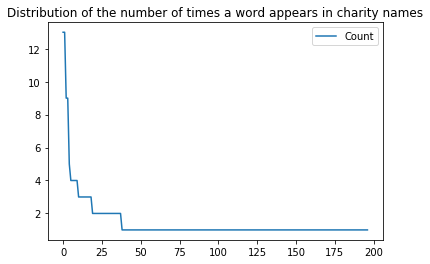

In [82]:
big_words.plot(title='Distribution of the number of times a word appears in charity names')

In [83]:
big_words.describe()

,Count
count,197.000000
mean,1.487310
std,1.573405
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,13.000000


We can see that most words appear only once. Let's take a look at the more frequent ones.

In [89]:
common_words = big_words[big_words['Count'] > 1]
common_words.describe()

,Count
count,38.000000
mean,3.526316
std,2.797072
min,2.000000
25%,2.000000
50%,2.500000
75%,3.750000
max,13.000000


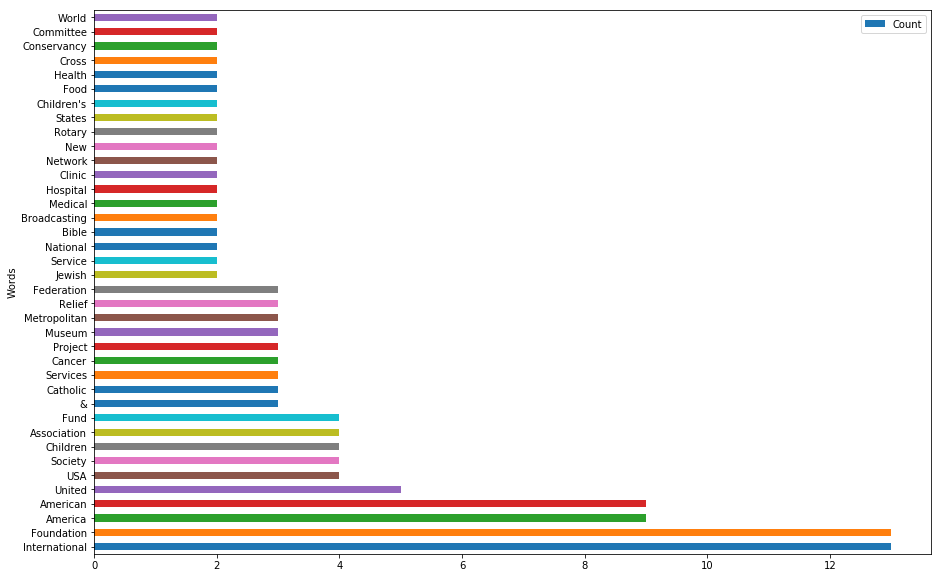

In [97]:
common_words.plot(kind='barh', x='Words', y='Count', figsize=(15, 10))

We can see that while there are a few "generic" words (World, Committee, Society), some of the them are rather specialized (Hospital, Food, Children's). These are the ones that should help us track down charities in the panama papers.

__Headquarters__

Since it is possible to cross-check addresses in the panama papers, we also look at headquarters.

In [109]:
hq = pd.DataFrame(df['Headquarters'])
hq['Count'] = 1
hq_frequency = hq.groupby('Headquarters').count().sort_values(by='Count', ascending=False).reset_index()
hq_frequency.head(5)

,Headquarters,Count
0,"New York, New York",23
1,"Washington, District of Columbia",10
2,"Alexandria, Virginia",5
3,"Chicago, Illinois",5
4,"Arlington, Virginia",3


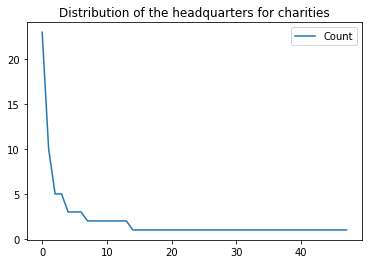

In [110]:
hq_frequency.plot(title='Distribution of the headquarters for charities')

We see that quite a few charities are concentrated in a few places.

In [112]:
most_frequent = hq_frequency[hq_frequency['Count'] > 1]
most_frequent.describe()

,Count
count,14.000000
mean,4.714286
std,5.703286
min,2.000000
25%,2.000000
50%,2.500000
75%,4.500000
max,23.000000


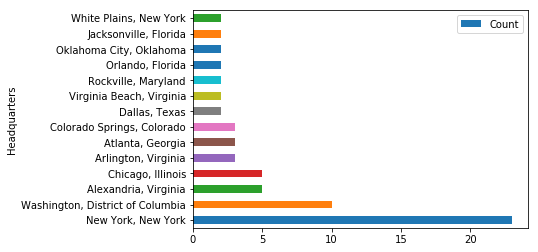

In [114]:
most_frequent.plot(kind='barh', x='Headquarters', y='Count')

Great! We have a point of reference to help us confirm whether a panama paper entity is in fact the charity with the same name!

In [115]:
df['Income($)'].describe()

count    1.000000e+02
mean     4.546900e+08
std      5.512227e+08
min      1.400000e+08
25%      1.847500e+08
50%      2.555000e+08
75%      5.102500e+08
max      3.708000e+09
Name: Income($), dtype: float64

Knowing the income isn't so important, but if we find any of these charities, it might give us an indicator of how lucrative storing money offshore is.